In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import json
tfk  = tf .keras
tfkl = tfk.layers

from utils import *
from tf_dataset_load_custom import image_dataset_from_directory
from tqdm import tqdm

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#299 (addative)

dim = 128
def get_autoencoder_model1(img_width=dim, img_height=dim):
    
    autoencoder = Sequential()
    # Encoder
    autoencoder.add(InputLayer(input_shape=(img_width, img_height, 1)))
    autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    autoencoder.add(MaxPooling2D((2, 2), padding='same'))
    autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    autoencoder.add(MaxPooling2D((2, 2), padding='same'))
    # Decoder
    autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling2D((2, 2)))
    autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling2D((2, 2)))
    autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    autoencoder.summary()
    return autoencoder

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
path = "imgmin/computed-ig"
#path = "out"
import pickle 

objs = []

for i, item in enumerate(os.listdir(path)):
    with open(path+"/"+item, 'rb') as fp:
        obj = pickle.load(fp)
    objs.append(obj)
    
    if i > 1000:
        break
        
print(len(objs))

1002


(2, 1, 299, 299, 3)
Max value in  4.9448376
Min value in  -5.2250037
[[ 7.75354783e-05 -1.63776567e-03  1.27330394e-02 ... -3.65683367e-03
  -5.11857169e-03 -1.24422208e-04]
 [ 4.39247675e-03  7.95716327e-03  2.48698238e-02 ... -3.30549269e-03
  -8.11462943e-03  3.11055896e-03]
 [ 9.20855999e-03  3.01874634e-02  4.18214537e-02 ... -1.19898273e-02
  -2.03368310e-02 -1.43347802e-02]
 ...
 [ 1.45741424e-03  1.35173381e-03  5.86217130e-03 ...  2.20207889e-02
   1.13879135e-02 -4.11796063e-04]
 [ 5.06124343e-04  6.13260418e-05  4.56466526e-03 ...  7.90650491e-03
  -9.26335109e-04 -1.18798681e-03]
 [-1.46433013e-04  1.06599543e-03 -5.84078720e-04 ...  2.99004023e-03
  -3.29999509e-03 -3.87639826e-04]]


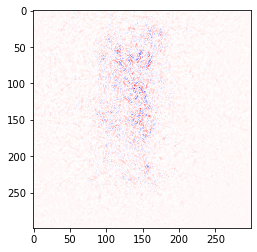

In [4]:
print(np.stack(obj["igs"]).shape)

img = np.concatenate(obj["igs"]).mean((0,-1))

for i,curr in enumerate(objs):
    objs[i] = np.concatenate(curr["igs"]).mean((0,-1))
    objs[i] = objs[i][:-3,:-3] #scale to 296
    #print(objs[i].shape)
    
print('Max value in ', img.max())
print('Min value in ', img.min())

print(img)

plt.imshow(img,cmap = "bwr")

Max value in  0.9923769
Min value in  -0.013218355
(1002, 296, 296, 1) <class 'numpy.ndarray'>


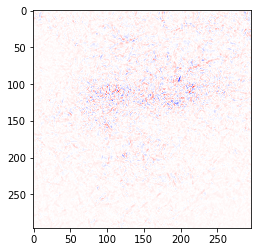

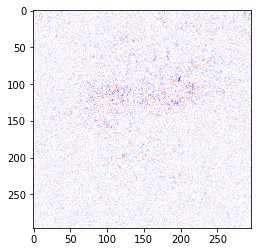

(1002, 296, 296, 1)
(1002, 296, 296, 1)


In [5]:
indata = np.array(objs)
indata = (indata[...,tf.newaxis] +10)/20

print('Max value in ', indata[0].max())
print('Min value in ', indata[0].min())

indata_noise = indata.copy()

print(indata_noise.shape, type(indata_noise))

plt.imshow(indata_noise[0],cmap = "bwr")
plt.show()

#add gaussian noise
var = 0.05
indata_noise += np.random.normal(0, var, indata_noise.shape) 

indata = tf.clip_by_value(indata, clip_value_min=0., clip_value_max=1.)
indata_noise = tf.clip_by_value(indata_noise, clip_value_min=0., clip_value_max=1.)

plt.imshow(indata_noise[0],cmap = "bwr")
plt.show()

print(indata_noise.shape)
print(indata.shape)

In [16]:
bs=4
e=4

split =True
lr = 1e-6
validation_split=0.3

dim = 296

model = get_autoencoder_model1(dim,dim)

#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss='mse')

if split ==True:
    model.fit(indata_noise, indata, epochs=e,batch_size=bs, validation_split=validation_split)
#else:
#    model.fit(x_train_noisy, x_train, epochs=e,batch_size=bs,shuffle=True, validation_data=(x_test_noisy, x_test))

pics = model.predict(indata_noise)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 296, 296, 64)      640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 148, 148, 64)     0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 148, 148, 128)     73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 128)      0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 74, 74, 128)       147584    
                                                                 
 up_sampling2d_6 (UpSampling  (None, 148, 148, 128)   

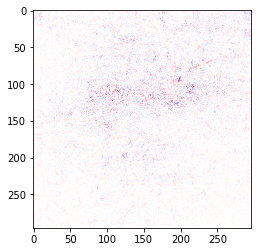

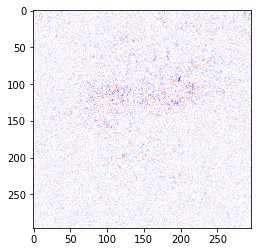

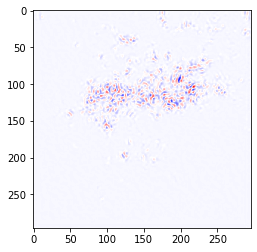

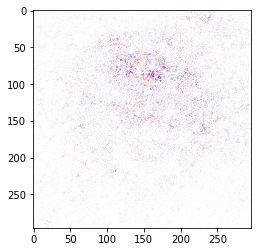

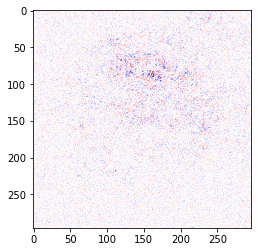

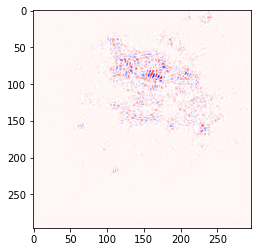

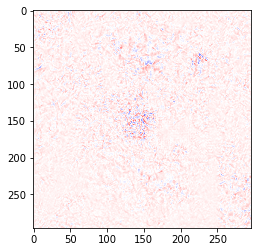

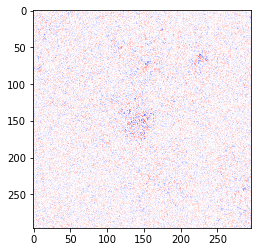

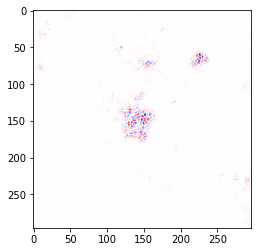

In [18]:
import matplotlib.pyplot as plt

pics = model.predict(indata)

n = 3 
for i in range(n): 
    plt.imshow(indata[i],cmap = "bwr")
    plt.show()
    plt.imshow(indata_noise[i],cmap = "bwr")
    plt.show()
    plt.imshow(pics[i],cmap = "bwr")
    plt.show()

In [ ]:
#Do not use


print(obj.keys())

print(obj["res"].shape)
print(obj["p5"].shape)
print(obj["y"])    
    
img = np.concatenate(obj["res"]).mean((0,-1))

plt.imshow(img,cmap = "bwr")
